In [1]:
%pip install -U pyobjc-framework-Quartz pyobjc-framework-Vision

Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2
import numpy as np
import glob
import Quartz
import Vision
import CoreFoundation
from Cocoa import NSURL
from Foundation import NSDictionary, NSArray
import matplotlib.pyplot as plt

import requests as req

from glob import glob
from tqdm import tqdm
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import pandas as pd

In [4]:
all_papers=req.get("https://sigir2025.dei.unipd.it/detailed-program/rest/papers").json()

In [5]:
import json
with open("sigir2025_papers.json", "w") as f:
    json.dump(all_papers, f, indent=2)

In [6]:
all_papers

{'resource-list': [{'paper': {'hashed_id': 'e02e27e04fdff967ba7d76fb24b8069d',
    'title': 'The Agent Perspective In LLM-Based Strategic Information Retrieval Ecosystems',
    'abstract': 'The rise of generative AI and the emergence of Large Language Models (LLMs) have sparked a new line of research on the evolution of strategic information retrieval ecosystems. My research adopts an agent-based perspective to analyze sponsored search and competitive search ecosystems. The primary motivation of my work is to examine how agent strategies influence social welfare and the existence of equilibrium. To that end, I leverage frameworks from game theory and mechanism design.',
    'doi': '10.1145/3726302.3730125',
    'sheridan_id': 'dc2601',
    'position': 2,
    'track_id': 11,
    'slot_id': 45}},
  {'paper': {'hashed_id': '32b991e5d77ad140559ffb95522992d0',
    'title': 'Continuous Evaluation in Information Retrieval Across Methods and Time',
    'abstract': 'Evaluating Information Retri

In [7]:
df_papers = pd.DataFrame([p["paper"] for p in all_papers['resource-list']])
df_papers.head()

,hashed_id,title,abstract,doi,sheridan_id,position,track_id,slot_id
0,e02e27e04fdff967ba7d76fb24b8069d,The Agent Perspective In LLM-Based Strategic I...,The rise of generative AI and the emergence of...,10.1145/3726302.3730125,dc2601,2,11,45
1,32b991e5d77ad140559ffb95522992d0,Continuous Evaluation in Information Retrieval...,Evaluating Information Retrieval (IR) systems ...,10.1145/3726302.3730124,dc2600,1,11,48
2,50abc3e730e36b387ca8e02c26dc0a22,Search Efficiency for Score-at-a-Time Retrieval,"Impact-ordered indexes, and thus Score-at-a-Ti...",10.1145/3726302.3730123,dc2599,1,11,50
3,67478479ad1213a3e9341881175ee3b6,Federated Recommender System Based on Diffusio...,Sequential recommender systems often struggle ...,10.1145/3688570,TOIS-2024-0040.R1,0,2,0
4,1175defd049d3301e047ce50d93e9c7a,From Professional Search to Generative Deep Re...,Generative AI (GenAI) models are increasingly ...,10.1145/3726302.3730131,dc2612,3,11,43


In [8]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
)
tfidf.fit(df_papers["title"].fillna(""))
tfidf.get_feature_names_out()

array(['1m', '1st', '1st nip', ..., 'μds multi', 'ℓ0',
       'ℓ0 sparsification'], shape=(5679,), dtype=object)

In [9]:
nn = NearestNeighbors(n_neighbors=1, metric="cosine").fit(
    tfidf.transform(
        df_papers["title"].fillna("") + " " + df_papers["abstract"].fillna("")
    )
)
result_dist, result_idx = nn.kneighbors(tfidf.transform(["TITE"]))
df_papers.iloc[result_idx[0]]

,hashed_id,title,abstract,doi,sheridan_id,position,track_id,slot_id
213,81e5f81db77c596492e6f1a5a792ed53,TITE: Token-Independent Text Encoder for Infor...,Transformer-based retrieval approaches typical...,10.1145/3726302.3730094,fp1250,2,1,33


In [10]:
def order_points(pts):
    """Rearrange coordinates to order:
    top-left, top-right, bottom-right, bottom-left"""
    rect = np.zeros((4, 2), dtype="float32")
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect.astype("int").tolist()


def find_dest(pts):
    (tl, tr, br, bl) = pts
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]

    return order_points(destination_corners)


def scan(img, name=""):
    # Resize image to workable size
    dim_limit = 1920
    max_dim = max(img.shape)
    if max_dim > dim_limit:
        resize_scale = dim_limit / max_dim
        img = cv2.resize(img, None, fx=resize_scale, fy=resize_scale)
    # Create a copy of resized original image for later use
    orig_img = img.copy()
    # Repeated Closing operation to remove text from the document.
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
    # GrabCut
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (20, 20, img.shape[1] - 20, img.shape[0] - 20)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
    img = img * mask2[:, :, np.newaxis]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)
    # Edge Detection.
    canny = cv2.Canny(gray, 0, 200)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    # Finding contours for the detected edges.
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Keeping only the largest detected contour.
    page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    # Detecting Edges through Contour approximation.
    # Loop over the contours.
    if len(page) == 0:
        return orig_img
    candidates = []
    for c in page:
        # Approximate the contour.
        epsilon = 0.02 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)
        area = cv2.contourArea(corners)
        # If our approximated contour has four points.
        if len(corners) == 4:
            candidates.append((corners, area))
    if len(candidates) == 0:
        return orig_img
    candidates.sort(key=lambda x: x[1], reverse=True)
    corners = candidates[0][0]
    print(candidates)
    # Sorting the corners and converting them to desired shape.
    corners = sorted(np.concatenate(corners).tolist())
    # For 4 corner points being detected.
    corners = order_points(corners)

    destination_corners = find_dest(corners)

    h, w = orig_img.shape[:2]
    # Getting the homography.
    M = cv2.getPerspectiveTransform(
        np.float32(corners), np.float32(destination_corners)
    )
    # Perspective transform using homography.
    final = cv2.warpPerspective(
        orig_img,
        M,
        (destination_corners[2][0], destination_corners[2][1]),
        flags=cv2.INTER_LINEAR,
    )
    return final

In [11]:
imgs = glob("figures/posters/initial/*.png")
# for img in tqdm(imgs):
#     print(img)
#     img_dat=cv2.imread(img)
#     final=scan(img_dat)
#     cv2.imwrite('out/'+img.split('/')[-1], final)
len(imgs)

0

In [12]:
def make_request_handler_img(results):
    """results: list to store results"""
    if not isinstance(results, list):
        raise ValueError("results must be a list")

    def handler(request, error):
        if error:
            print(f"Error! {error}")
        else:
            observations: "list[Vision.VNRecognizedTextObservation]" = request.results()
            for text_observation in observations:
                recognized_text = text_observation.topCandidates_(1)[0]
                corners = {
                    "tl": text_observation.topLeft(),
                    "tr": text_observation.topRight(),
                    "bl": text_observation.bottomLeft(),
                    "br": text_observation.bottomRight(),
                }
                corners = {k: (v.x, v.y) for k, v in corners.items()}
                results.append(
                    [recognized_text.string(), recognized_text.confidence(), corners]
                )

    return handler


def image_to_text(
    img_path, lang="eng"
) -> "list[tuple[str, float, dict[str,tuple[float,float]]]]":
    input_url = NSURL.fileURLWithPath_(img_path)

    input_image = Quartz.CIImage.imageWithContentsOfURL_(input_url)

    vision_options = NSDictionary.dictionaryWithDictionary_({})

    vision_handler = Vision.VNImageRequestHandler.alloc().initWithCIImage_options_(
        input_image, vision_options
    )
    results = []
    handler = make_request_handler_img(results)
    vision_request = Vision.VNRecognizeTextRequest.alloc().initWithCompletionHandler_(
        handler
    )
    # print(vision_request.recognitionLanguages())
    vision_request.setRecognitionLanguages_(
        NSArray.arrayWithArray_(
            [
                lang,
            ]
        )
    )
    # vision_request.setCustomWords_(NSArray.arrayWithArray_(['für',]))
    # print(type(vision_request.recognitionLanguages()))
    # print(vision_request.recognitionLanguages())
    vision_request.setUsesCPUOnly_(False)  # somehow improves accuracy??
    error = vision_handler.performRequests_error_([vision_request], None)

    return results

In [13]:
def find_dest_doc(pts):
    (tl, tr, br, bl) = pts
    # Finding the maximum width.
    widthA = np.sqrt(((br - bl) ** 2).sum())
    widthB = np.sqrt(((tr - tl) ** 2).sum())
    maxWidth = max(int(widthA), int(widthB))

    # Finding the maximum height.
    heightA = np.sqrt(((tr - br) ** 2).sum())
    heightB = np.sqrt(((tl - bl) ** 2).sum())
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [
        [0, 0],
        [maxWidth, 0],
        [0, maxHeight],
        [maxWidth, maxHeight],
    ]

    return destination_corners


def make_request_handler_doc(results):
    """results: list to store results"""
    if not isinstance(results, list):
        raise ValueError("results must be a list")

    def handler(request, error):
        if error:
            print(f"Error! {error}")
        else:
            observations = request.results()
            for obs in observations:
                # print(obs)
                # print(obs.bottomLeft())
                # print(obs.bottomRight())
                bbox = obs.boundingBox()
                corners = {
                    "tl": obs.topLeft(),
                    "tr": obs.topRight(),
                    "bl": obs.bottomLeft(),
                    "br": obs.bottomRight(),
                }
                corners = {k: (v.x, v.y) for k, v in corners.items()}
                results.append(
                    {
                        "bbox": corners,
                        "bbox_obj": bbox,
                        "conf": obs.confidence(),
                    }
                )

    return handler


def image_doc_handler(img_path: str) -> str:
    input_url = NSURL.fileURLWithPath_(img_path)

    input_image = Quartz.CIImage.imageWithContentsOfURL_(input_url)

    vision_options = NSDictionary.dictionaryWithDictionary_({})

    vision_handler = Vision.VNImageRequestHandler.alloc().initWithCIImage_options_(
        input_image, vision_options
    )
    results = []
    handler = make_request_handler_doc(results)
    vision_request = (
        Vision.VNDetectDocumentSegmentationRequest.alloc().initWithCompletionHandler_(
            handler
        )
    )
    # print(vision_request.recognitionLanguages())
    # vision_request.setRecognitionLanguages_(NSArray.arrayWithArray_([lang,]))
    # vision_request.setCustomWords_(NSArray.arrayWithArray_(['für',]))
    # print(type(vision_request.recognitionLanguages()))
    # print(vision_request.recognitionLanguages())
    # vision_request.setUsesCPUOnly_(False) # somehow improves accuracy??
    error = vision_handler.performRequests_error_([vision_request], None)

    return results


res = image_doc_handler(imgs[0])
res

IndexError: list index out of range

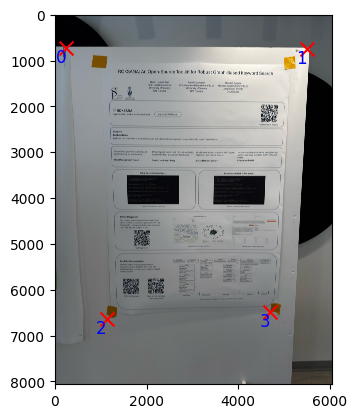

In [ ]:
img = imgs[1]
res = image_doc_handler(img)
img_dat = cv2.imread(img)
src=np.array([
    res[0]["bbox"]["tl"],
    res[0]["bbox"]["tr"],
    res[0]["bbox"]["bl"],
    res[0]["bbox"]["br"],
])
# src = np.array([list(p) for p in res[0]["bbox"].values()])
dst = np.array(
    [
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1],
    ]
)
shape = np.flip(img_dat.shape[:2])
src = src * shape
dst_scaled = find_dest_doc(src)
src_flipped_y = np.copy(src)
src_flipped_y[:, 1] = shape[1] - src[:, 1]
plt.imshow(cv2.cvtColor(img_dat, cv2.COLOR_BGR2RGB))
plt.scatter(src_flipped_y[:, 0], src_flipped_y[:, 1], marker="x", color="red", s=100)
for i, (x, y) in enumerate(src_flipped_y):
    plt.text(x, y, str(i), color="blue", fontsize=12, ha="right", va="top")

In [ ]:
dst_scaled

[[0, 0], [0, 7333], [5250, 0], [5250, 7333]]

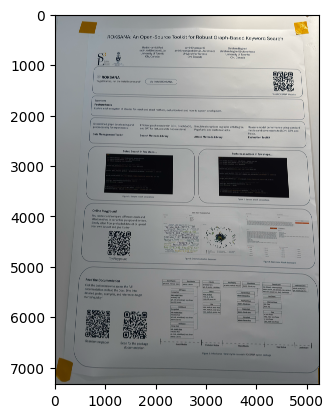

In [ ]:
dst_mtx= np.array(dst_scaled).astype("float32")
src_mtx = np.array(src_flipped_y).astype("float32")
M = cv2.getPerspectiveTransform(src_mtx,dst_mtx)
dst_size=tuple(dst_mtx.max(axis=0).astype('int').tolist())

warped = cv2.warpPerspective(img_dat, M, dst_size, flags=cv2.INTER_LINEAR)
# warped_flipped=cv2.
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

In [ ]:
dst_size

(5250, 7333)

In [14]:
def extract_poster_img(img: str):
    res = image_doc_handler(img)
    img_dat = cv2.imread(img)
    src = np.array([list(p) for p in res[0]["bbox"].values()])
    shape = np.flip(img_dat.shape[:2])
    src = src * shape
    dst_scaled = find_dest_doc(src)
    src_flipped_y = np.copy(src)
    src_flipped_y[:, 1] = shape[1] - src[:, 1]

    dst_mtx= np.array(dst_scaled).astype("float32")
    src_mtx = np.array(src_flipped_y).astype("float32")
    M = cv2.getPerspectiveTransform(src_mtx,dst_mtx)
    dst_size=tuple(dst_mtx.max(axis=0).astype('int').tolist())

    warped = cv2.warpPerspective(img_dat, M, dst_size, flags=cv2.INTER_LINEAR)

    return warped


for img in tqdm(imgs):
    img_path = Path(img)
    warped = extract_poster_img(img)
    target_path = img_path.parent.parent / "warped" / img_path.parts[-1]

    cv2.imwrite(str(target_path), warped)

0it [00:00, ?it/s]


In [15]:
def authors_text(texts):
    results = texts
    for textbox in results:
        commas = (
            textbox[0].count(",")
            + textbox[0].count("and")
            + textbox[0].count("&")
            + textbox[0].count(".")
        )

        textbox.append(commas)
    results.sort(key=lambda x: x[-1], reverse=True)
    return results[0][0] if len(results) else ""


def biggest_text(texts):
    results = texts
    for textbox in results:
        dims = textbox[2]
        poss = np.array([dims["tl"], dims["tr"], dims["br"], dims["bl"]]).astype(
            np.float32
        )
        area = cv2.contourArea(poss)
        textbox.append(area)
    results.sort(key=lambda x: x[-1], reverse=True)
    return results[0][0] if len(results) else ""

In [16]:
outs = glob("figures/posters/warped/*.png")
for img in tqdm(outs):
    img_dat = cv2.imread(img)
    # downscale image
    dim_limit = 1080
    max_dim = max(img_dat.shape)
    if max_dim > dim_limit:
        resize_scale = dim_limit / max_dim
        img_dat = cv2.resize(img_dat, None, fx=resize_scale, fy=resize_scale)
    cv2.imwrite("figures/posters/reduced/" + img.split("/")[-1], img_dat)

100%|██████████| 11/11 [00:06<00:00,  1.63it/s]


In [17]:
data = []

for img in tqdm(outs):
    texts = image_to_text(img, "eng")
    title = biggest_text(texts)
    authors = authors_text(texts)

    # print(title, authors)
    data.append(
        {
            "title": title,
            "authors": authors,
            "texts": texts,
            "img": img,
            "img_reduced": Path(img).parent.parent / "reduced" / Path(img).parts[-1],
        }
    )

100%|██████████| 11/11 [00:33<00:00,  3.08s/it]


In [18]:
data_df=pd.DataFrame(data)
data_df.head()

,title,authors,texts,img,img_reduced
0,"Benjamin Vendeville[1, 2,3], Liana Ermakova[2]...",0.56 0.35 0.15 0.06 0.10 0.04 0.11 0.07 0.17 0.14,[[0.56 0.35 0.15 0.06 0.10 0.04 0.11 0.07 0.17...,figures/posters/warped/IMG_3569.png,figures/posters/reduced/IMG_3569.png
1,ROKSANA: An Open-Source Toolkit for Robust Gra...,"equeries, gold set, resus before, k. values-15...","[[equeries, gold set, resus before, k. values-...",figures/posters/warped/IMG_3555.png,figures/posters/reduced/IMG_3555.png
2,PlausibleQA - A Large-Scale QA Dataset with An...,"100,000 annotated candidate answers, and 1,000...","[[100,000 annotated candidate answers, and 1,0...",figures/posters/warped/IMG_3568.png,figures/posters/reduced/IMG_3568.png
3,• Larger models and larger context sizes produ...,"the generated text G = (5,... Sm with attribut...","[[the generated text G = (5,... Sm with attrib...",figures/posters/warped/IMG_3563.png,figures/posters/reduced/IMG_3563.png
4,REANIMATOR,"Björn Engelmann, Fabian Haak, Philipp Scher, M...","[[Björn Engelmann, Fabian Haak, Philipp Scher,...",figures/posters/warped/IMG_3565.png,figures/posters/reduced/IMG_3565.png


In [19]:
data_df["url"] = ""
data_df["abstract"] = ""

In [20]:
df_papers

,hashed_id,title,abstract,doi,sheridan_id,position,track_id,slot_id
0,e02e27e04fdff967ba7d76fb24b8069d,The Agent Perspective In LLM-Based Strategic I...,The rise of generative AI and the emergence of...,10.1145/3726302.3730125,dc2601,2,11,45
1,32b991e5d77ad140559ffb95522992d0,Continuous Evaluation in Information Retrieval...,Evaluating Information Retrieval (IR) systems ...,10.1145/3726302.3730124,dc2600,1,11,48
2,50abc3e730e36b387ca8e02c26dc0a22,Search Efficiency for Score-at-a-Time Retrieval,"Impact-ordered indexes, and thus Score-at-a-Ti...",10.1145/3726302.3730123,dc2599,1,11,50
3,67478479ad1213a3e9341881175ee3b6,Federated Recommender System Based on Diffusio...,Sequential recommender systems often struggle ...,10.1145/3688570,TOIS-2024-0040.R1,0,2,0
4,1175defd049d3301e047ce50d93e9c7a,From Professional Search to Generative Deep Re...,Generative AI (GenAI) models are increasingly ...,10.1145/3726302.3730131,dc2612,3,11,43
...,...,...,...,...,...,...,...,...
552,af5afd7f7c807171981d443ad4f4f648,NAM: A Normalization Attention Model for Perso...,Personalized product search provides significa...,10.1145/3726302.3730235,sp1576,6,3,111
553,c91591a8d461c2869b9f535ded3e213e,An Alternative to FLOPS Regularization to Effe...,Learned Sparse Retrieval (LSR) models encode t...,10.1145/3726302.3730163,sp1904,44,3,111
554,ba9a56ce0a9bfa26e8ed9e10b2cc8f46,Squeeze and Excitation: A Weighted Graph Contr...,Contrastive Learning (CL) has recently emerged...,10.1145/3726302.3730251,sp1876,41,3,111
555,c5b2cebf15b205503560c4e8e6d1ea78,WebClasSeg-25: A Dual-Classified Webpage Segme...,Webpage segmentation is a crucial task in web ...,10.1145/3726302.3730309,rr1998,103,7,110


In [21]:
for i, row in tqdm(data_df.iterrows(), total=len(data_df)):
    title = row["title"]
    authors = row["authors"]
    k_nn=1
    
    result_dist, result_idx = nn.kneighbors(
        tfidf.transform([title + " " + authors])
    )
    result=df_papers.iloc[result_idx[0]]
    
    data_df.loc[i, "url"] = f"https://doi.org/{result['doi'].values[0]}"
    data_df.loc[i, "title"] = result["title"].values[0]
    data_df.loc[i, "abstract"] = result["abstract"].values[0]

100%|██████████| 11/11 [00:00<00:00, 555.47it/s]


In [22]:
from pylatex.utils import escape_latex

In [ ]:
with open("./posters.tex", "w") as f:
    f.write("| **Poster** | **Title** | **Information** | \n")
    separator="| -- | -- | -- | \n"
    f.write(separator)
    lines=[
        f'| ![poster](figures/posters/reduced/{poster["img"].split("/")[-1]}) | {poster["title"].replace("|", " ")} | *{escape_latex(poster["authors"].replace("|", " "))}*, [{escape_latex(poster["title"].replace("≥", " "))}]({escape_latex(poster["url"])}) | \n' for i,poster in data_df.iterrows()
    ]
    f.write("".join(lines))
    